In [2]:
import torch
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap

In [3]:
#import the data
org = torch.load("../originals.pt")
aug = torch.load("../augmentations.pt")
labels = torch.load("../labels.pt")
nn_indices = torch.load("../nn_indices.pt")

dataset = AugRepresentationDataset(aug,org,labels)



In [4]:
reducer = umap.UMAP(n_components=2,random_state=42,metric="cosine")
emb = reducer.fit_transform(org)


/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
dataloader = DataLoader(dataset,batch_size=200,shuffle=True)

In [5]:
def MI_loss(logits,lamb=1.0,tau=1.0,eps=1e-10):
    "logits are shape (bs,n,k)"
    bs,n,k = logits.shape

    p = F.softmax(logits,dim=2)

    #compute the estimate of the 
    #joint probability distribution
    J = torch.einsum('bik,bjc->ijkc',p,p) 
    J = J.mean(dim=(0,1)) / bs  #shape (k,k) / 

    #marginal probabilities
    P1 = J.mean(dim=0).unsqueeze(1)
    P2 = J.mean(dim=1).unsqueeze(0)
    
    logk = torch.log(torch.tensor(k))
    Joint_entropy = - (J * torch.log(J + eps)).sum() / logk  # positive 
    Marginal_entropy = - (J * torch.log(P1*P2 + eps)).sum() / logk  # positive

    #compute the loss
    return Joint_entropy - Marginal_entropy*lamb 

def FCE_loss(logits,tau=1.0,eps=1e-10):

    bs,n,k = logits.shape

    p = F.softmax(logits,dim=2)
    
    #compute the shared class fuzzy estimate
    B = torch.einsum('bik,cjk->ijbc',p,p)
    B = B.mean(dim=(0,1)) #shape (bs,bs)
    
    #get the negative targets
    N = B.tril(diagonal=-1)
    N = 1-N +eps
    #assume the negative targets come from a 
    #distribution that has mean 1/k 
    neg_targets = torch.zeros_like(N)
    neg_targets = 1-neg_targets.tril(diagonal=-1)

    #compute the negative loss
    #compute a contrastive loss 
    Pos_pair_CE = -torch.log(B.diagonal()).sum()
    Neg_pair_CE = -(neg_targets*torch.log(N)).sum()

    return Pos_pair_CE + tau * Neg_pair_CE

def fce_loss(logits, tau=1.0, eps=1e-10):
    """
    Fuzzy Contrastive Entropy (FCE) Loss.
    This loss function applies the principles of contrastive learning by comparing
    the average cluster assignments of instances in the batch.

    Args:
        logits (torch.Tensor): The output from the network. Shape: (bs, n, k)
                               bs = batch size, n = num augmentations, k = num clusters.
        tau (float): A weighting factor for the negative pair loss.
        eps (float): Small value for numerical stability.
    """
    bs, n, k = logits.shape

    # Apply softmax to get probability distributions for each augmentation
    p = F.softmax(logits, dim=2) # Shape: (bs, n, k)

    # Average the probabilities across augmentations for each instance.
    # This gives a single representative probability vector per instance.
    p_mean = p.mean(dim=1) # Shape: (bs, k)

    # --- Calculate the Similarity Matrix ---
    # We compute a (bs, bs) similarity matrix where S_ij is the dot product
    # between the mean probability vectors of instance i and instance j.
    similarity_matrix = torch.matmul(p_mean, p_mean.t()) # Shape: (bs, bs)
    
    # Clamp for stability
    similarity_matrix = torch.clamp(similarity_matrix, min=eps, max=1.0)

    # --- Positive Pair Loss ---
    # The positive loss encourages the diagonal elements of the similarity matrix
    # to be close to 1. This means the dot product of an instance's average
    # probability vector with itself should be high.
    pos_loss = -torch.log(similarity_matrix.diagonal()).sum()

    # --- Negative Pair Loss ---
    # The negative loss encourages the off-diagonal elements to be close to 0.
    # This pushes the average representations of different instances apart.
    neg_mask = 1 - torch.eye(bs, device=logits.device)
    neg_sim = similarity_matrix * neg_mask
    
    # Minimize similarity, so minimize -log(1 - similarity)
    neg_loss = -torch.log(1 - neg_sim[neg_mask > 0] + eps).sum()

    return pos_loss + tau * neg_loss


In [17]:
from src.models.clustering import MLP_dict    

In [ ]:
model = MLP_dict(K_range=[10],lamb_range=np.arange(10),num_copies=10)
device = 'cuda'
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0003)
dataset = TensorDataset(aug,org,torch.tensor(emb),labels)
dataloader = DataLoader(dataset,batch_size=400,shuffle=True,drop_last=True)

In [ ]:
evals = [ ]
losses = []

loss_dict = {key:[] for key in model.keys}
for epoch in range(10):
    temp_loss = {key:[] for key in model.keys}
    
    loading_bar = tqdm.tqdm(dataloader,desc=f"Epoch {epoch+1}")
    for xt,x,e,y in loading_bar:
        optimizer.zero_grad()
        xt = xt[:,torch.randperm(10)[:5],:].to(device)
        p_dict = model(xt)
        loss = 0
        for key in p_dict.keys():
            lossval = MI_loss(p_dict[key],lamb=1.1**key[0]) +
            temp_loss[key].append(lossval.item())
            loss += lossval
        loss = loss/len(p_dict.keys())
        loss.backward()
        optimizer.step()
    
    for key in temp_loss.keys():
        loss_dict[key].append(np.mean(temp_loss[key]))
    
    

Epoch 2:  33%|███▎      | 35/106 [00:04<00:08,  8.45it/s]


KeyboardInterrupt: 

In [107]:
0.9**np.arange(15)

array([1.        , 0.9       , 0.81      , 0.729     , 0.6561    ,
       0.59049   , 0.531441  , 0.4782969 , 0.43046721, 0.38742049,
       0.34867844, 0.3138106 , 0.28242954, 0.25418658, 0.22876792])

In [108]:
1.2**-6

0.3348979766803842

In [109]:
#get all the evals
test_dataloader = DataLoader(dataset,batch_size=1000,shuffle=False)
predictions = {key:[] for key in model.keys}
with torch.no_grad():
    for x1,x,e,y in test_dataloader:
        x = x.to(device)
        p = model(x)
        for key in p.keys():
            predictions[key].append(p[key].argmax(dim=1).cpu())

predictions = {key:torch.cat(predictions[key]) for key in predictions.keys()}
eval_mat = torch.zeros(10,10)
for key in predictions.keys():
    eval_mat[key[0],key[2]] = nmi(predictions[key],labels)




<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_487548/621100611.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


Text(50.722222222222214, 0.5, '$\\tau$')

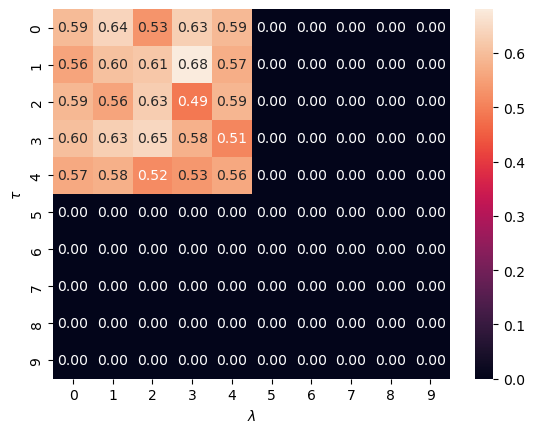

In [110]:
sns.heatmap(eval_mat,annot=True,fmt='.2f')
plt.xlabel("$\lambda$")
plt.ylabel("$\\tau$")

<Axes: title={'center': 'Predicted Clusters (Neural Network)'}>

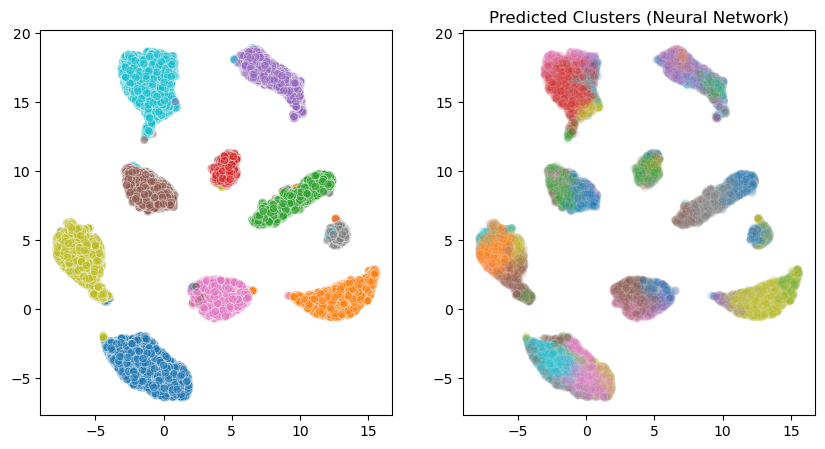

In [99]:
pred_clus = predictions[(2,10,2)]
f,a = plt.subplots(1,2,figsize=(10,5))
a[1].set_title("Predicted Clusters (Neural Network)")
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=labels,palette="tab10",alpha=0.5,ax=a[0],legend=False)
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=pred_clus,palette="tab10",alpha=0.1,ax=a[1],legend=False)


In [ ]:
np.sort(np.unique(P_sym_dense))

In [ ]:
sim27 = (reps[2] @ reps[7].T)
sim22 = (reps[2] @ reps[2].T)
sim77 = (reps[7] @ reps[7].T)

In [ ]:
sim27.mean(),sim22.mean(),sim77.mean()

(tensor(0.6576), tensor(0.7939), tensor(0.8823))